# ML. New York City Taxi Trip Duration
<img src=https://www.kaggle.com/competitions/6960/images/header align="right" width="300"> 

## 1. Задача проекта
Построить модель ML, которая будет предсказывать общую продолжительность поездки такси в Нью-Йорке. 

Известно, что стоимость такси в США  рассчитывается на основе фиксированной ставки + тарифная стоимость, величина которой зависит от времени и расстояния. Тарифы варьируются в зависимости от города.

В свою очередь время поездки зависит от множества факторов таких как, откуда и куда вы едете, в какое время суток вы совершаете вашу поездку, погодных условий и так далее. 

Таким образом, мы должны разработать алгоритм, способный определять длительность поездки, и тогда вы сможете прогнозировать ее стоимость, просто умножая стоимость на заданный тариф. 

***Бизнес-задача:*** определить характеристики и с их помощью спрогнозировать длительность поездки такси (задача регрессии).

## 2. Знакомство с данными, базовый анализ и расширение данных

В случае необходимости вы можете загрузить источники на свой локальный компьютер:
- тренировочный датасет: https://drive.google.com/file/d/1X_EJEfERiXki0SKtbnCL9JDv49Go14lF/view
- тестовый датасет: https://drive.google.com/file/d/1C2N2mfONpCVrH95xHJjMcueXvvh_-XYN/view?usp=sharing
- файл с праздничными датами: https://lms-cdn.skillfactory.ru/assets/courseware/v1/33bd8d5f6f2ba8d00e2ce66ed0a9f510/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/holiday_data.csv
- файл с георгафическим данными OSRM для тренировочного набора: https://drive.google.com/file/d/1ecWjor7Tn3HP7LEAm5a0B_wrIfdcVGwR/view?usp=sharing
- файл с георгафическим данными OSRM для тестового набора: https://drive.google.com/file/d/1wCoS-yOaKFhd1h7gZ84KL9UwpSvtDoIA/view?usp=sharing
- набор данных о погодных условиях в Нью-Йорке в 2016 году: https://lms-cdn.skillfactory.ru/assets/courseware/v1/0f6abf84673975634c33b0689851e8cc/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/weather_data.zip

Импортируем модули, которые нам понадобятся для решения задачи:

In [1]:
import numpy as np                      # для матричных вычислений
import pandas as pd                     # для анализа и обработки данных
import matplotlib.pyplot as plt         # для визуализации данных, графическом отображении факторов и их зависимостей
import seaborn as sns                   # для визуализации данных, графическом отображении факторов и их зависимостей

from scipy import stats                 # для решения математических задач
from sklearn import linear_model        # модуль линейных алгоритмов библиотеки машинного обучения
from sklearn import preprocessing       # модуль подготовки данных для подачи их в модель
from sklearn import model_selection     # модуль иструментов разбиения данных, использования перекрестной проверки и улучшения качества моделей
from sklearn import tree                # модуль алгоритма ML дерева решений
from sklearn import ensemble            # модуль ансамблевых алгоритмов ML
from sklearn import metrics             # метрические функции оценки ошибки прогноза
from sklearn import cluster             # модуль алгоритмов кластеризации
from sklearn import feature_selection   # модуль алгоритмов отбора факторов перед подачей в модель

import warnings
warnings.filterwarnings('ignore')

Прочитаем тренировочный файл с исходными данными:

In [2]:
taxi_data = pd.read_csv('data/Project5_train_data.zip')
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Итак, данные содержат 11 характеристик почти 1.5 миллионов поездок. 

Условно разделим признаки на нескольких групп:\
**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах.

### 2.1 Общий обзор, подготовка и очистка данных.
Посмотрим на временные рамки, представленные в датасете.

In [3]:
# преобразуем временные признаки в правильный формат с помощью функции to_datetime()
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
taxi_data['dropoff_datetime'] = pd.to_datetime(taxi_data['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')

print('Presented period pickup: {} - {}'.format(taxi_data['pickup_datetime'].dt.date.min(), taxi_data['pickup_datetime'].dt.date.max()))
print('Presented period dropoff: {} - {}'.format(taxi_data['dropoff_datetime'].dt.date.min(), taxi_data['dropoff_datetime'].dt.date.max()))

Presented period pickup: 2016-01-01 - 2016-06-30
Presented period dropoff: 2016-01-01 - 2016-07-01


Проверим данные на пропуски.

In [4]:
taxi_data.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

Посмотрим общие статистические характеристики признаков. 

In [5]:
print(taxi_data.describe(include=['object']).T)
np.round(taxi_data.describe().T, 2)

                      count   unique        top     freq
id                  1458644  1458644  id2875421        1
store_and_fwd_flag  1458644        2          N  1450599


,count,mean,std,min,25%,50%,75%,max
vendor_id,1458644.0,1.53,0.50,1.00,1.00,2.00,2.00,2.00
passenger_count,1458644.0,1.66,1.31,0.00,1.00,1.00,2.00,9.00
pickup_longitude,1458644.0,-73.97,0.07,-121.93,-73.99,-73.98,-73.97,-61.34
pickup_latitude,1458644.0,40.75,0.03,34.36,40.74,40.75,40.77,51.88
dropoff_longitude,1458644.0,-73.97,0.07,-121.93,-73.99,-73.98,-73.96,-61.34
dropoff_latitude,1458644.0,40.75,0.04,32.18,40.74,40.75,40.77,43.92
trip_duration,1458644.0,959.49,5237.43,1.00,397.00,662.00,1075.00,3526282.00


*Итак,*\
*- данные о поездках предоставлены от двух таксопарков,*\
*-признак сохранения сообщения о поездке и отправки его поставщику 'store_and_fwd_flag' можно назвать неиформативным, потому что  99,44% поездок без сохранения сведений,*\
*-признак 'id' - уникален и тем самым не информативен,*\
*-не все поездки содержат сведения о количестве пассажиров, мы наблюдаем указание - 0 пассажиров,*\
*-имеются аномальные выбросы в целевом признаке, например, поездка в 40,81 часов (3526282 сек.), а также поездки в 1 секунду.*

### 2.2 Расширение исходного набора данных внешними источниками, преобразование имеющихся признаков.

#### 2.2.1 Преобразование временного признака 'pickup_datetime'.
Создадим функцию add_datetime_features(), которая принимает на вход исходную таблицу с данными о поездках и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - порядковый номер дня недели (число, 0-понедельник, 6-воскресенье), в который был включен счетчик.

In [6]:
# создаем функцию
def add_datetime_features(data):
    # применим атрибуты date, hour and dayofweek функции datetime(dt) к признаку 'pickup_datetime'
    data['pickup_date'] = data['pickup_datetime'].dt.date 
    data['pickup_hour'] = data['pickup_datetime'].dt.hour   
    data['pickup_day_of_week'] = data['pickup_datetime'].dt.dayofweek
    return data
# применяем функцию
add_datetime_features(taxi_data)
# проверка преобразования
print(taxi_data[['pickup_date', 'pickup_hour', 'pickup_day_of_week']].head())
print('Quantity of trips daily:', np.round(taxi_data['pickup_date'].count()/taxi_data['pickup_date'].nunique()))

  pickup_date  pickup_hour  pickup_day_of_week
0  2016-03-14           17                   0
1  2016-06-12            0                   6
2  2016-01-19           11                   1
3  2016-04-06           19                   2
4  2016-03-26           13                   5
Quantity of trips daily: 8015.0


#### 2.2.2 Добавление сведений о праздничных днях.
Создадим функцию add_holiday_features(), которая принимает на вход две таблицы: таблицу с данными о поездках и таблицу с данными о праздничных днях.\
Возвращает функция обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет). 

In [7]:
# загружаем файл с праздничными датами
holiday_data = pd.read_csv('data/holiday_data.csv', sep=';')
# создаем функцию
def add_holiday_features(data1, data2):
    # преобразуем столбец датафрейма с праздниками в список
    holidays = data2['date'].tolist()
    # если дата поездки в такси совпадает с датой из списка, то определяем значение как 1, если нет - 0
    data1['pickup_holiday'] = data1['pickup_date'].apply(lambda x: 1 if str(x) in holidays else 0)
    return data1
# применим функцию
add_holiday_features(taxi_data, holiday_data)
# проверим, столько поездков было в праздничным дни
print('Quantity of trips in working days(0, %) and holidays(1, %): ', taxi_data['pickup_holiday'].value_counts()*100/len(taxi_data), sep='\n')

Quantity of trips in working days(0, %) and holidays(1, %): 
0    96.495238
1     3.504762
Name: pickup_holiday, dtype: float64


#### 2.2.3 Дополнение датасета географическими данными.

Мы используем OSRM (Open Source Routing Machine) — это ресурс, который позволяет построить оптимальный кусочно-линейный путь из точки А в точку B, а также узнать его примерную длительность и длину. 

Создадим функцию add_osrm_features(), которая принимает на вход две таблицы: таблицу с данными о поездках и таблицу с данными из OSRM.\
Функция возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance - кратчайшее дорожное расстояние (в метрах) из точки, в которой был включён счётчик, до точки, в которой счётчик был выключен (согласно OSRM);
* total_travel_time - наименьшее время поездки (в секундах) из точки, в которой был включён счётчик, до точки, в которой счётчик был выключен (согласно OSRM);
* number_of_steps - количество дискретных шагов, которые должен выполнить водитель (поворот налево/поворот направо/ехать прямо и т. д.).

*Примечание.* Время поездки, вычисляемое с помощью OSRM, не является истинным временем поездки, так как оно вычисляется по кратчайшему пути при идеальных условиях: отсутствие пробок, погодных влияний и других внешних факторов. 

In [8]:
# создаем список столбцов, которые необходимо нам подгрузить из источника
cols = ['id', 'total_distance', 'total_travel_time', 'number_of_steps']
osrm_data = pd.read_csv('data/osrm_data_train.zip', usecols = cols)
osrm_data.head()

,id,total_distance,total_travel_time,number_of_steps
0,id2875421,2009.1,164.9,5
1,id2377394,2513.2,332.0,6
2,id3504673,1779.4,235.8,4
3,id2181028,1614.9,140.1,5
4,id0801584,1393.5,189.4,5


In [9]:
# создаем функцию
def add_osrm_features(data1, data2):
    # к датасету о поездках присоединяем новые столбцы по общему признаку id
    data = data1.merge(data2, on='id', how='left')
    return data
# применим функцию
taxi_data = add_osrm_features(taxi_data, osrm_data)
taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,total_distance,total_travel_time,number_of_steps
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,0,0,2009.1,164.9,5.0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,6,0,2513.2,332.0,6.0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,1,0,11060.8,767.6,16.0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,2,0,1779.4,235.8,4.0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,5,0,1614.9,140.1,5.0


Введём в наш анализ расстояние по формуле гаверсинуса. 
Данная формула определяет кратчайшее расстояние между двумя точками на сфере, если известны широта и долгота каждой из точек. Геометрически это длина кратчайшей дуги, связывающей точки на сфере.

Пусть есть две точки с географическими координатами $x_1 = (\varphi_1, \lambda_1)$ и $x_2 = (\varphi_2, \lambda_2)$, где
* $\varphi_1, \lambda_1$ — широта (latitude) и долгота (longitude) первой точки маршрута (в радианах);
* $\varphi_2, \lambda_2$ — широта (latitude) и долгота (longitude) второй точки маршрута (в радианах).

Тогда расстояние по формуле гаверсинуса (в километрах) определяется как:
$$h(x_1,x_2) = 2R \ arcsin (\sqrt{sin^2 (\frac{\varphi_2 - \varphi_1}{2}) + cos(\varphi_1) cos(\varphi_2) sin (\frac{\lambda_2 - \lambda_1}{2})})$$
где R — радиус земли (6371 км), h — расстояние между двумя точками на сфере (в километрах).

Расстояние, вычисляемое в OSRM, — это кратчайший суммарный путь, пройденный по дорожным разметкам.\
Если принять Землю за плоскость, то можно показать, что расстояние по формуле гаверсинуса превратится в евклидово расстояние. Тогда величина  будет длиной гипотенузы прямоугольного треугольника, а вот расстояние из OSRM будет равно сумме длин катетов.

Зная начальную и конечную точку маршрута, мы можем вычислить направление движения автомобиля (угол пеленга) по формуле:
$$\alpha = arctg (\frac{sin (\lambda_2 - \lambda_1) cos (\varphi_2)}{cos (\varphi_1) sin (\varphi_2) - sin (\varphi_1) cos (\varphi_2) cos (\lambda_2 - \lambda_1)})$$
где $\alpha$ — угол направления движения от первой точки ко второй (может измеряться как в радианах, так и в градусах).

Создадим следующие функции:
* get_haversine_distance — функция для вычисления расстояния по формуле гаверсинуса (в километрах);
* get_angle_direction — функция для вычисления угла направления движения (в градусах).

Каждая из функций имеет четыре аргумента:
* lat1 и lng1 — векторы-столбцы с широтой и долготой первой точки;
* lat2 и lng2 — векторы-столбцы с широтой и долготой второй точки.

In [10]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371 
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

Создадим функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

In [11]:
def add_geographical_features(data):
    # применим созданные ранее функции вычисления
    data['haversine_distance'] = get_haversine_distance(data['pickup_latitude'], data['pickup_longitude'], data['dropoff_latitude'], data['dropoff_longitude'])
    data['direction'] = get_angle_direction(data['pickup_latitude'], data['pickup_longitude'], data['dropoff_latitude'], data['dropoff_longitude'])
    return data
# применим функцию
add_geographical_features(taxi_data)
# проверяем добавление новых признаков
taxi_data[['haversine_distance', 'direction']].head()

,haversine_distance,direction
0,1.498521,99.970196
1,1.805507,-117.153768
2,6.385098,-159.680165
3,1.485498,-172.737700
4,1.188588,179.473585


#### 2.2.4 Кластеризация по географическим координатам.
Сгруппируем все поездки в зависимости от координат начала и конца поездки с помощью методов кластеризации, мы добавим признак районов, в которых находятся точки старта и конца поездки. Возможно, что длительность поездки зависит от того, к какому географическому кластеру принадлежит поездка.

В качестве метода кластеризации воспользуемся алгоритмом K-Means. Возьмём десять кластеров и обучим его на данных, сформированных из широты и долготы всех точек начала и конца поездок.

Создадим функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках.\
Функция возвращает обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

In [12]:
def add_cluster_features(data):
    # создаем обучающую выборку из географических координат всех точек
    coords = np.hstack((data[['pickup_latitude', 'pickup_longitude']],
                    data[['dropoff_latitude', 'dropoff_longitude']]))
    # обучаем алгоритм кластеризации
    kmeans = cluster.KMeans(n_clusters=10, random_state=42)
    kmeans.fit(coords)
    # делаем предсказание
    predictions = kmeans.predict(coords)
    # создаем новый признак на основе предсказаний
    data['geo_cluster'] = predictions
    return data
# применим функцию
add_cluster_features(taxi_data)
# посмотрим на распределение поездок по кластерам
taxi_data['geo_cluster'].value_counts()

0    595850
6    405045
9    322999
7     45791
3     40671
2     32769
8     15510
4         4
5         3
1         2
Name: geo_cluster, dtype: int64

#### 2.2.5 Создание новых признаков на основе внешних данных о погоде.
Погода является важным фактором, влияющим на дорожное движение. Например, снег и дождь могут затруднять движение и увеличивать время поездки.

Из файла с информацией о погодных условиях в Нью-Йорке в 2016 году нас интересуют следующие столбцы:
* time — дата измерения (с интервалом в час);
* temperature — температура;
* visibility — видимость;
* wind speed — средняя скорость ветра;
* precip — количество осадков;
* events — погодные явления: Rain — дождь, Snow — снег, Fog — туман, None — отсутствие погодных явлений.

Создадим функцию add_weather_features(), которая принимает на вход две таблицы: таблицу с данными о поездках и таблицу с данными о погодных условиях на каждый час.\
Функция возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

In [13]:
# создаем список интересующих нас столбцов
columns = ['time', 'temperature', 'visibility', 'wind speed', 'precip', 'events']
weather_data = pd.read_csv('data/weather_data.zip', usecols=columns)
weather_data.head()

,time,temperature,visibility,wind speed,precip,events
0,2015-12-31 02:00:00,7.8,8.0,5.6,0.8,None
1,2015-12-31 03:00:00,7.2,12.9,7.4,0.3,None
2,2015-12-31 04:00:00,7.2,12.9,0.0,0.0,None
3,2015-12-31 05:00:00,7.2,14.5,7.4,0.0,None
4,2015-12-31 06:00:00,7.2,11.3,5.6,0.0,None


In [14]:
# преобразуем признак 'time' из типа object в нужный формат времени datetime
weather_data['time'] = pd.to_datetime(weather_data['time'])
def add_weather_features(data1, data2):
    # с помощью атрибутов datetime отделяем дату и час в отдельные столбцы
    data2['date'] = data2['time'].dt.date
    data2['hour'] = data2['time'].dt.hour
    data = data1.merge(data2, left_on=['pickup_date', 'pickup_hour'], right_on=['date', 'hour'], how='left')
    return data.drop(['time', 'date', 'hour'], axis=1)
# применим функцию
taxi_data = add_weather_features(taxi_data, weather_data)
taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,total_travel_time,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,164.9,5.0,1.498521,99.970196,6,4.4,8.0,27.8,0.3,None
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,332.0,6.0,1.805507,-117.153768,9,28.9,16.1,7.4,0.0,None
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,767.6,16.0,6.385098,-159.680165,9,-6.7,16.1,24.1,0.0,None
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,235.8,4.0,1.485498,-172.737700,9,7.2,16.1,25.9,0.0,None
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,140.1,5.0,1.188588,179.473585,6,9.4,16.1,9.3,0.0,None


### 2.3 Заполнение пропусков в новых признаках, добавленных в исходный датасет о поездках.
Создадим функцию fill_null_weather_data(), которая принимает на вход которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполним медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки.\
Пропуски в столбце events заполним строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана). 

Пропуски в столбцах с информацией из OSRM - total_distance, total_travel_time и number_of_steps заполним медианным значением по столбцам. 

In [15]:
null_in_data = taxi_data.isnull().sum()
print('Features witn null: ', null_in_data[null_in_data > 0], sep='\n')
def fill_null_weather_data(data):
    cols = ['temperature', 'visibility', 'wind speed', 'precip']
    for col in cols:
        # сгруппируем данные по столбцу pickup_date (дата начала поездки) и рассчитаем медиану в каждой группе
        # заполним пропуски с помощью функции fillna()
        data[col] = data[col].fillna(data.groupby('pickup_date')[col].transform('median'))
    data['events'] = data['events'].fillna('None')
    cols2 = ['total_distance', 'total_travel_time', 'number_of_steps']
    for col in cols2:
        data[col] = data[col].fillna(data[col].median())
    return data

# применим функцию
fill_null_weather_data(taxi_data)

Features witn null: 
total_distance           1
total_travel_time        1
number_of_steps          1
temperature          12032
visibility           12032
wind speed           12032
precip               12032
events               12032
dtype: int64


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,total_travel_time,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,164.9,5.0,1.498521,99.970196,6,4.4,8.0,27.8,0.3,None
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,332.0,6.0,1.805507,-117.153768,9,28.9,16.1,7.4,0.0,None
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,767.6,16.0,6.385098,-159.680165,9,-6.7,16.1,24.1,0.0,None
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,235.8,4.0,1.485498,-172.737700,9,7.2,16.1,25.9,0.0,None
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,140.1,5.0,1.188588,179.473585,6,9.4,16.1,9.3,0.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,...,311.7,8.0,1.225080,-119.059338,0,7.8,16.1,11.1,0.0,None
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,...,589.6,11.0,6.049836,25.342196,6,7.2,2.8,18.5,8.1,Rain
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,...,642.9,10.0,7.824606,-150.788492,9,18.3,16.1,0.0,0.0,None
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,...,161.6,7.0,1.092564,35.033294,0,-2.8,16.1,9.3,0.0,None


### 2.4 Очистка целевой переменной 'trip_duration' (продолжительность поездки) от аномальных выбросов. 
Прежде всего, определимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа. 

В данных имеются аномалии в виде 'телепортаций' - перемещение на большие расстояния за считанные секунды. Для их вычисления можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси.Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом: 
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:

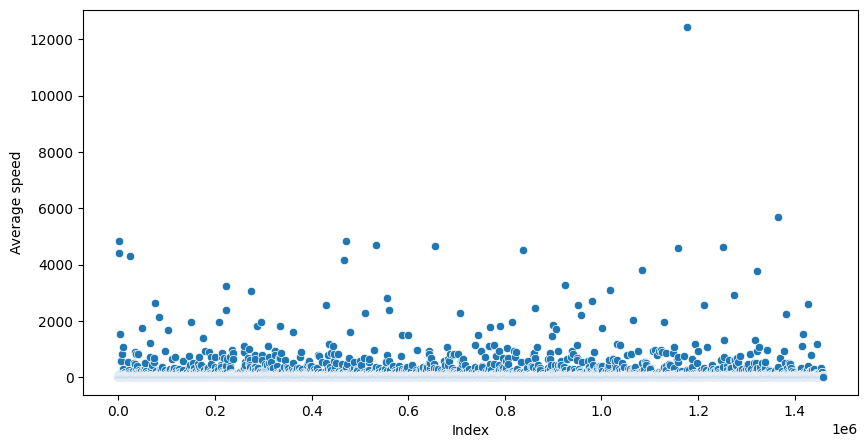

In [16]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

Итак мы видим, что у нас есть 'поездки-телепортации', для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч!\
Оставим поездки, где предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч. 

In [17]:
# определим поездки продолжительностью более 24 часов
duration_mask = taxi_data['trip_duration'] > (60*60*24)
print('Taxi trips over 24 hours: ', *taxi_data[duration_mask].index)
# посмотрим количество поездок со скоростью более 300км/час
print('Speed of taxis over 300km/hours: ', len(taxi_data[avg_speed > 300].index))

Taxi trips over 24 hours:  355003 680594 924150 978383
Speed of taxis over 300km/hours:  407


Удалим найденные аномалии, а также НЕинформативные признаки, которые мы обнаружили в начале.

In [18]:
taxi_data = taxi_data[(avg_speed < 300)&(taxi_data['trip_duration'] < (60*60*24))]
taxi_data.drop(['id', 'store_and_fwd_flag'], axis=1, inplace=True)
taxi_data.shape

(1458233, 24)

## 3. Разведывательный анализ данных (EDA)

Основной метрикой качества решения поставленной задачи в ML определим RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. Логарифмуем признак продолжительности поездки и будем рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1)$$

In [19]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

### 3.1 Визуализация распределения продолжительности поездок в логарифмическом масштабе (trip_duration_log). 
Исходя из визуализации, определим, является ли полученное распределение нормальным и проверим это статистически с помощью теста Д’Агостино (scipy.stats.normaltest).

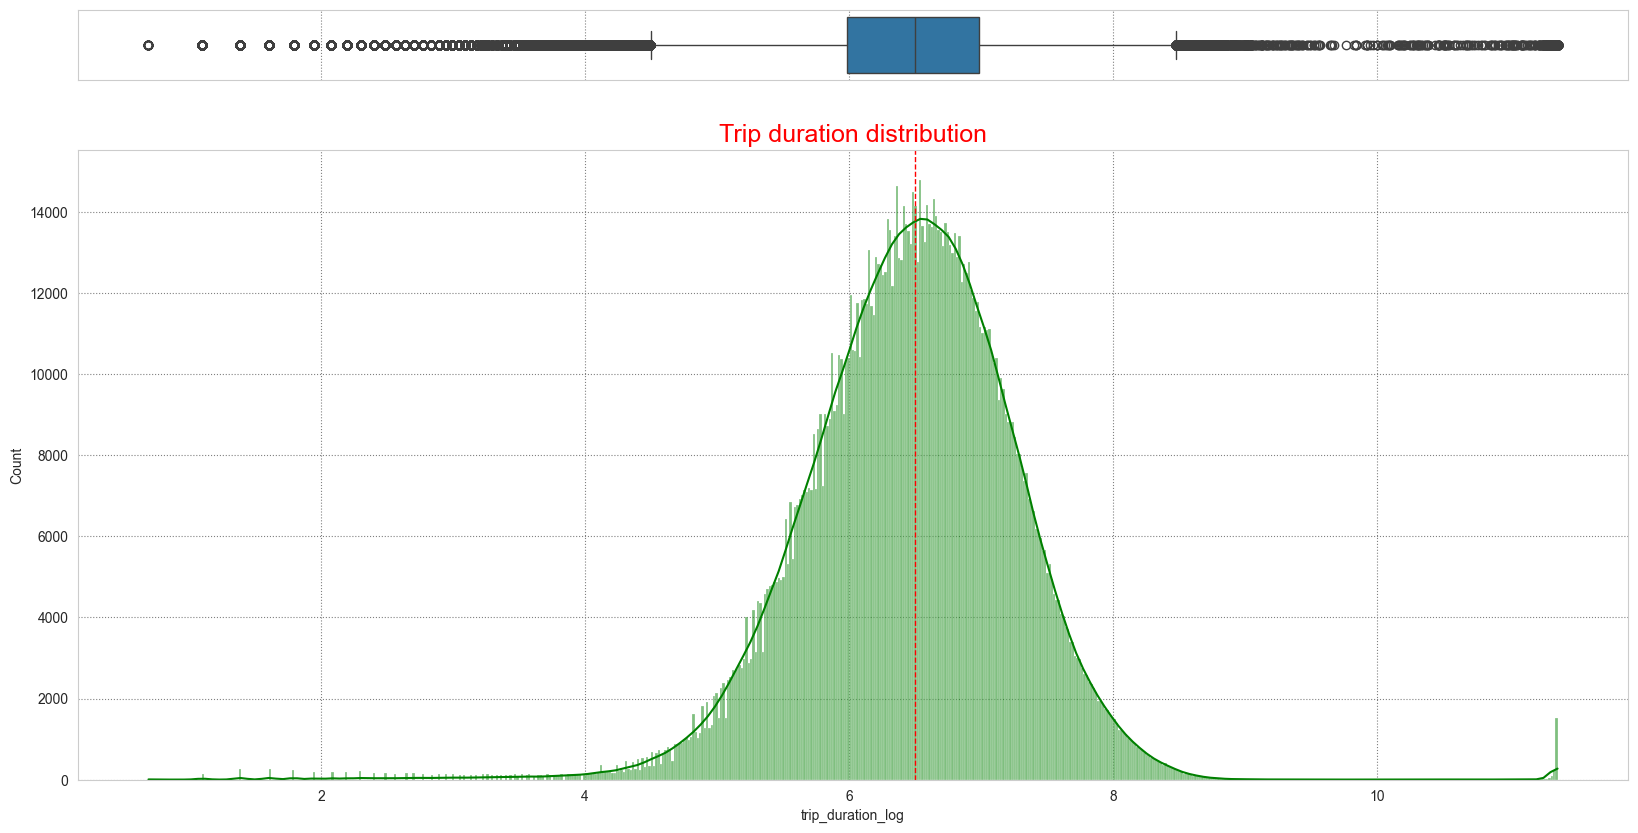

In [21]:
sns.set_style("whitegrid", {"grid.color": ".5", "grid.linestyle": ":"})
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios':{.10, .90}}, figsize = (20, 10)) # задаем размер координатной плоскости и соотношение графиков
# коробчатая диаграмма 
sns.boxplot(taxi_data['trip_duration_log'], orient="h", ax=ax_box)
# гистограмма
sns.histplot(taxi_data['trip_duration_log'], kde=True, color='green', ax=ax_hist)
ax_hist.axvline(taxi_data['trip_duration_log'].median(), color='red', linestyle='--', linewidth=1) # отобразим медианное значение
plt.title('Trip duration distribution', fontsize=18, color='r')
plt.show()

In [22]:
# задаем уровень значимости для проведения статистического теста
alpha = 0.05
__, p_v = stats.normaltest(taxi_data['trip_duration_log'])
print('p-value = {:.3f}'.format(p_v))
if p_v <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


***Вывод:***\
*Согласно графику, логарифмическое распределение целевого признака - продолжительность поездки можно отнести к нормальному распределению.*\
*Но благодаря тесту мы можем сказать, что распределение нельзя отнести к нормальному.*

### 3.2 Сравнение продолжительсти поездки (trip_duration_log) в зависимости от таксопарка (vendor_id).

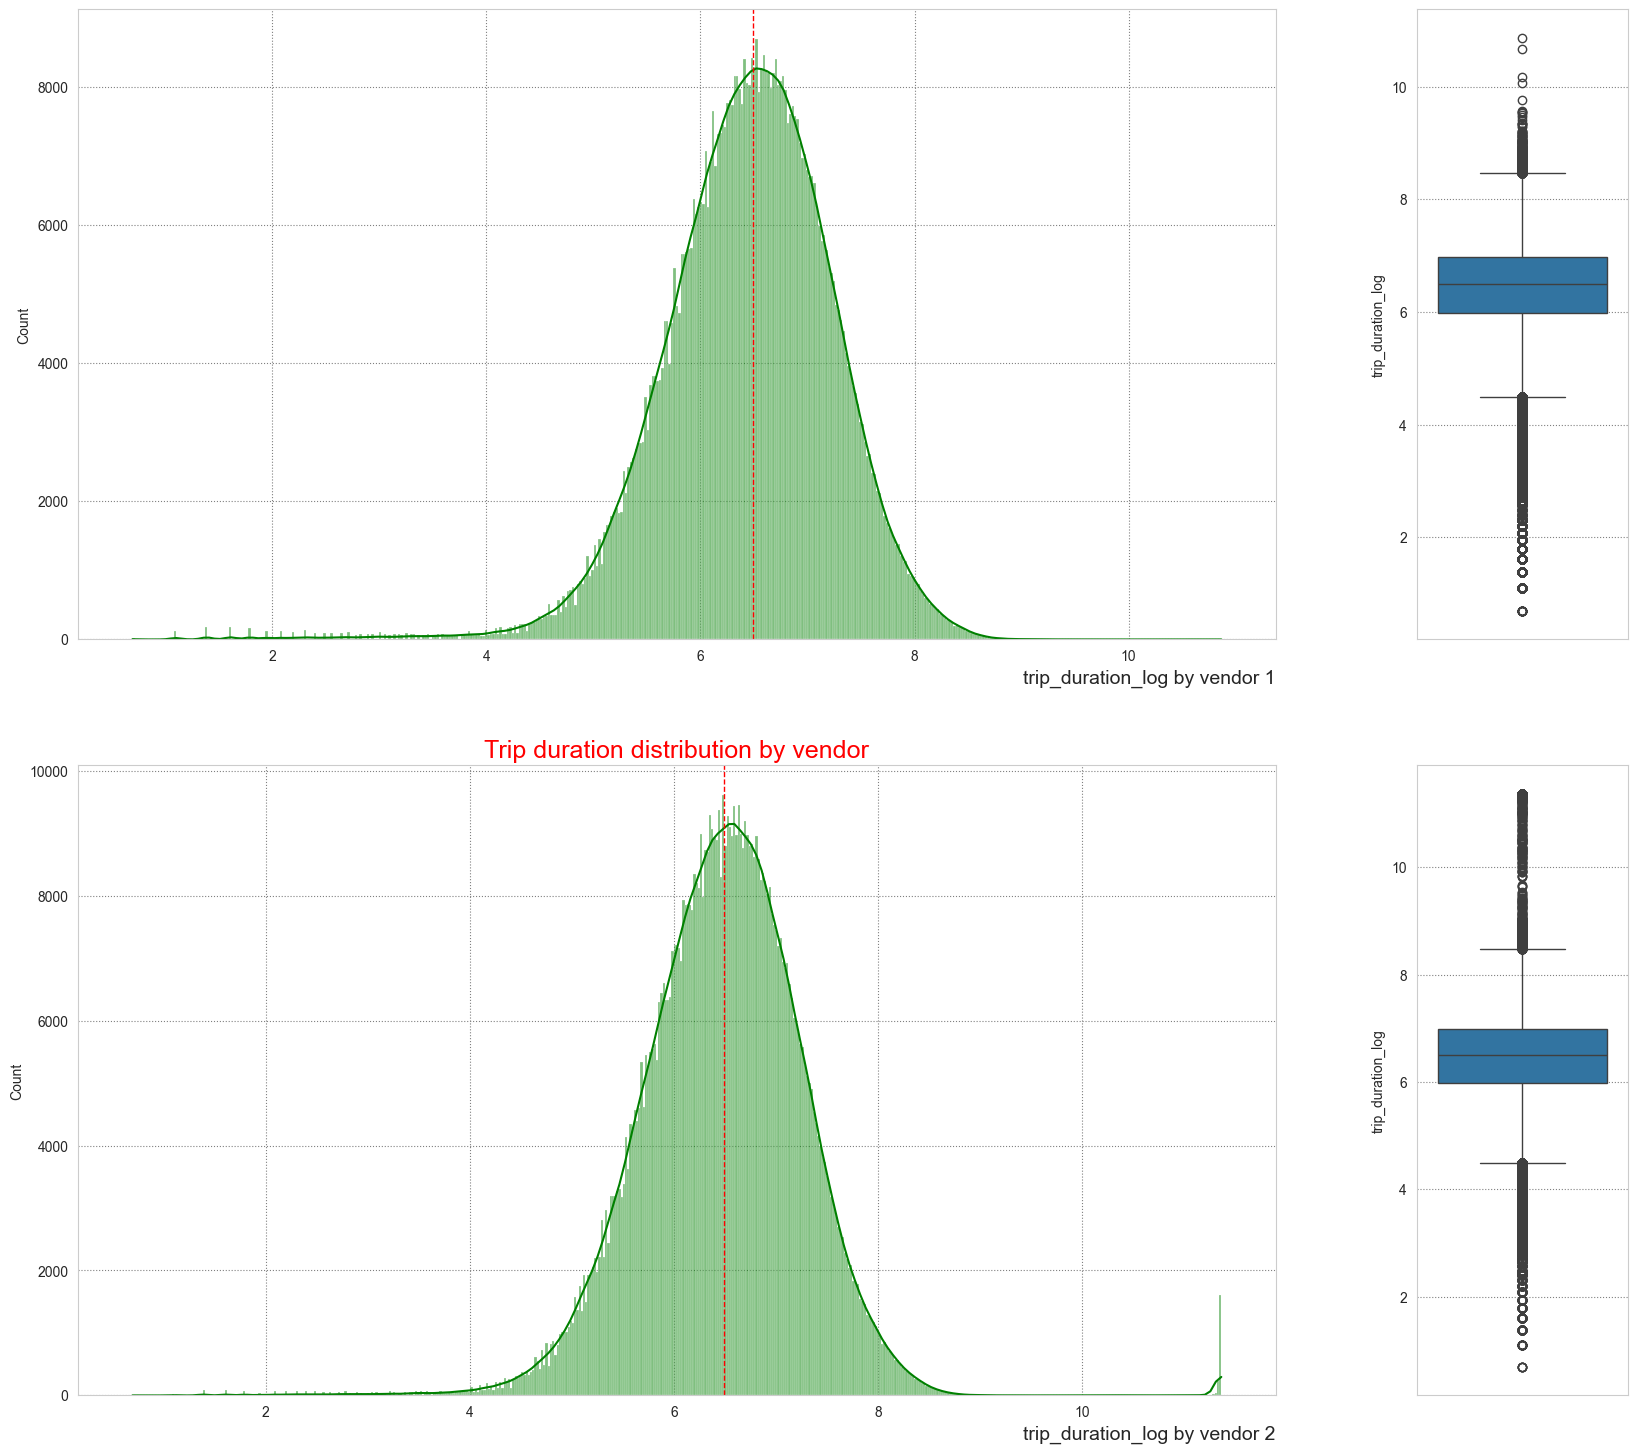

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(20, 18), gridspec_kw={'width_ratios':{.85, .15}})
# гистограмма распределения таксопарка №1
sns.histplot(x=taxi_data[taxi_data['vendor_id']==1]['trip_duration_log'], kde=True, color='green', ax = ax[0][0])
ax[0][0].set_xlabel('trip_duration_log by vendor 1', loc='right', fontsize=14)
ax[0][0].axvline(taxi_data[taxi_data['vendor_id']==1]['trip_duration_log'].median(), color='red', linestyle='--', linewidth=1) # отобразим медианное значение
# коробчатая диаграмма 'trip_duration_log' & 'vendor_id'=1
sns.boxplot(taxi_data[taxi_data['vendor_id']==1]['trip_duration_log'], orient='v', ax=ax[0][1])
# гистограмма распределения таксопарка №2
sns.histplot(x=taxi_data[taxi_data['vendor_id']==2]['trip_duration_log'], kde=True, color='green', ax=ax[1][0])
ax[1][0].set_xlabel('trip_duration_log by vendor 2', loc='right', fontsize=14)
ax[1][0].axvline(taxi_data[taxi_data['vendor_id']==1]['trip_duration_log'].median(), color='red', linestyle='--', linewidth=1) # отобразим медианное значение
ax[1][0].set_title('Trip duration distribution by vendor', loc='center', fontsize=18, color='r')
sns.boxplot(taxi_data[taxi_data['vendor_id']==2]['trip_duration_log'], orient='v', ax=ax[1][1])
plt.show()

***Вывод:***\
*Никакой значительной разницы между таксопарками мы не наблюдаем, можно предлоположить, что на продолжительность поездки не влияет, какой таксопарк, и данный признак не обладает большой значимостью для моделирования ML.*

### 3.3 Распределение продолжительности поездки (trip_duration_log) в рабочие и праздничные дни (pickup_holiday).

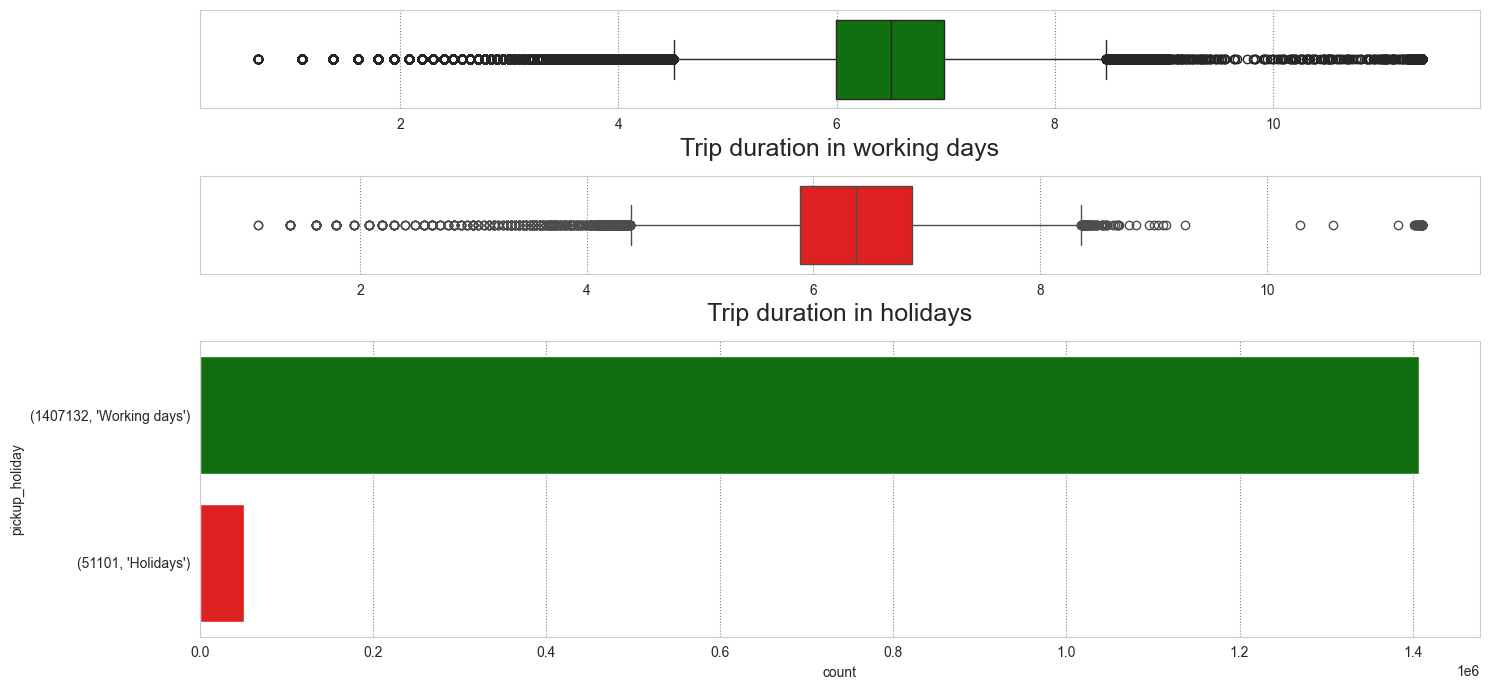

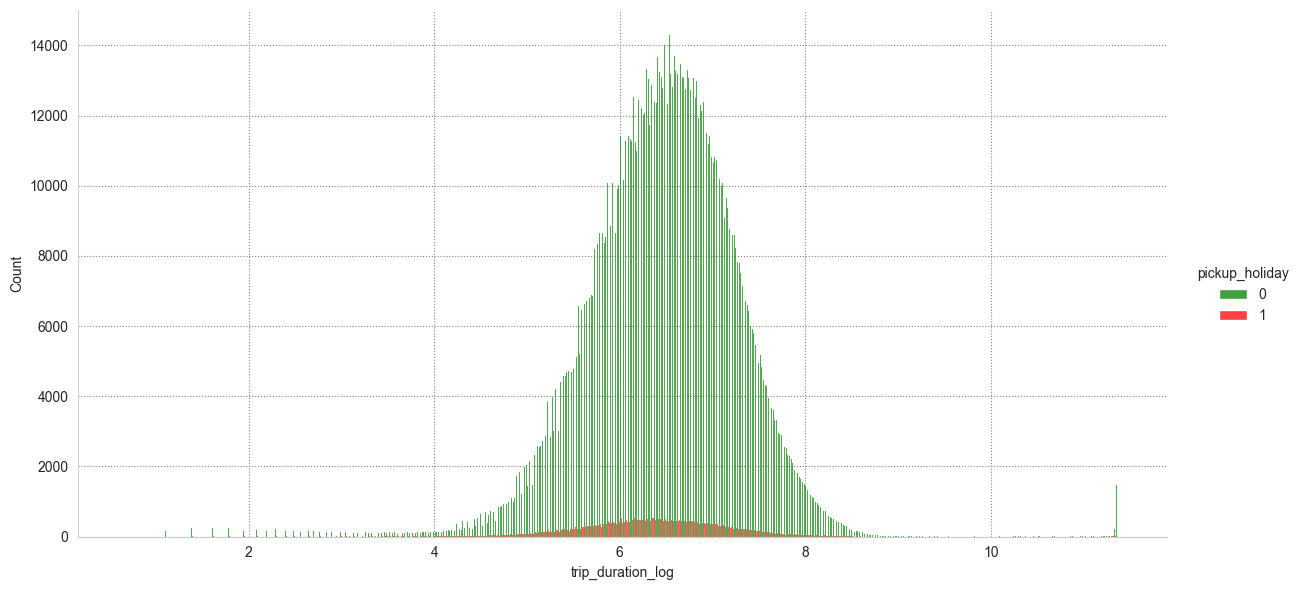

In [24]:
fig, (box1, box2, bar) = plt.subplots(3, 1, gridspec_kw={'height_ratios':[2, 2, 6]}, figsize = (15, 7))
sns.boxplot(taxi_data[taxi_data['pickup_holiday']==0]['trip_duration_log'], orient="h", color='green', ax=box1)
box1.set_xlabel('Trip duration in working days', fontsize=18)
sns.boxplot(taxi_data[taxi_data['pickup_holiday']==1]['trip_duration_log'], orient="h", color='red', ax=box2)
box2.set_xlabel('Trip duration in holidays', fontsize=18)
sns.countplot(data=taxi_data, y='pickup_holiday', palette=['green', 'red'], ax=bar)
bar.set_yticklabels(zip([taxi_data['pickup_holiday'].value_counts()[0], taxi_data['pickup_holiday'].value_counts()[1]],['Working days', 'Holidays']))
plt.tight_layout()
plt.show()

sns.displot(taxi_data, x='trip_duration_log', hue='pickup_holiday', palette=['green', 'red'], 
            multiple='dodge', kind='hist', height=6, aspect=2);

***Вывод:***\
*В праздничные дни продолжительность поездки меньше, возможно из-за меньшей загруженности на дороге, и значительно меньше поездок на длительные расстояния.*

### 3.4 Визуализация количества поездок в зависимости от часа дня (pickup_hour) и зависимость продолжительности поездок (trip_duration) от данного фактора.

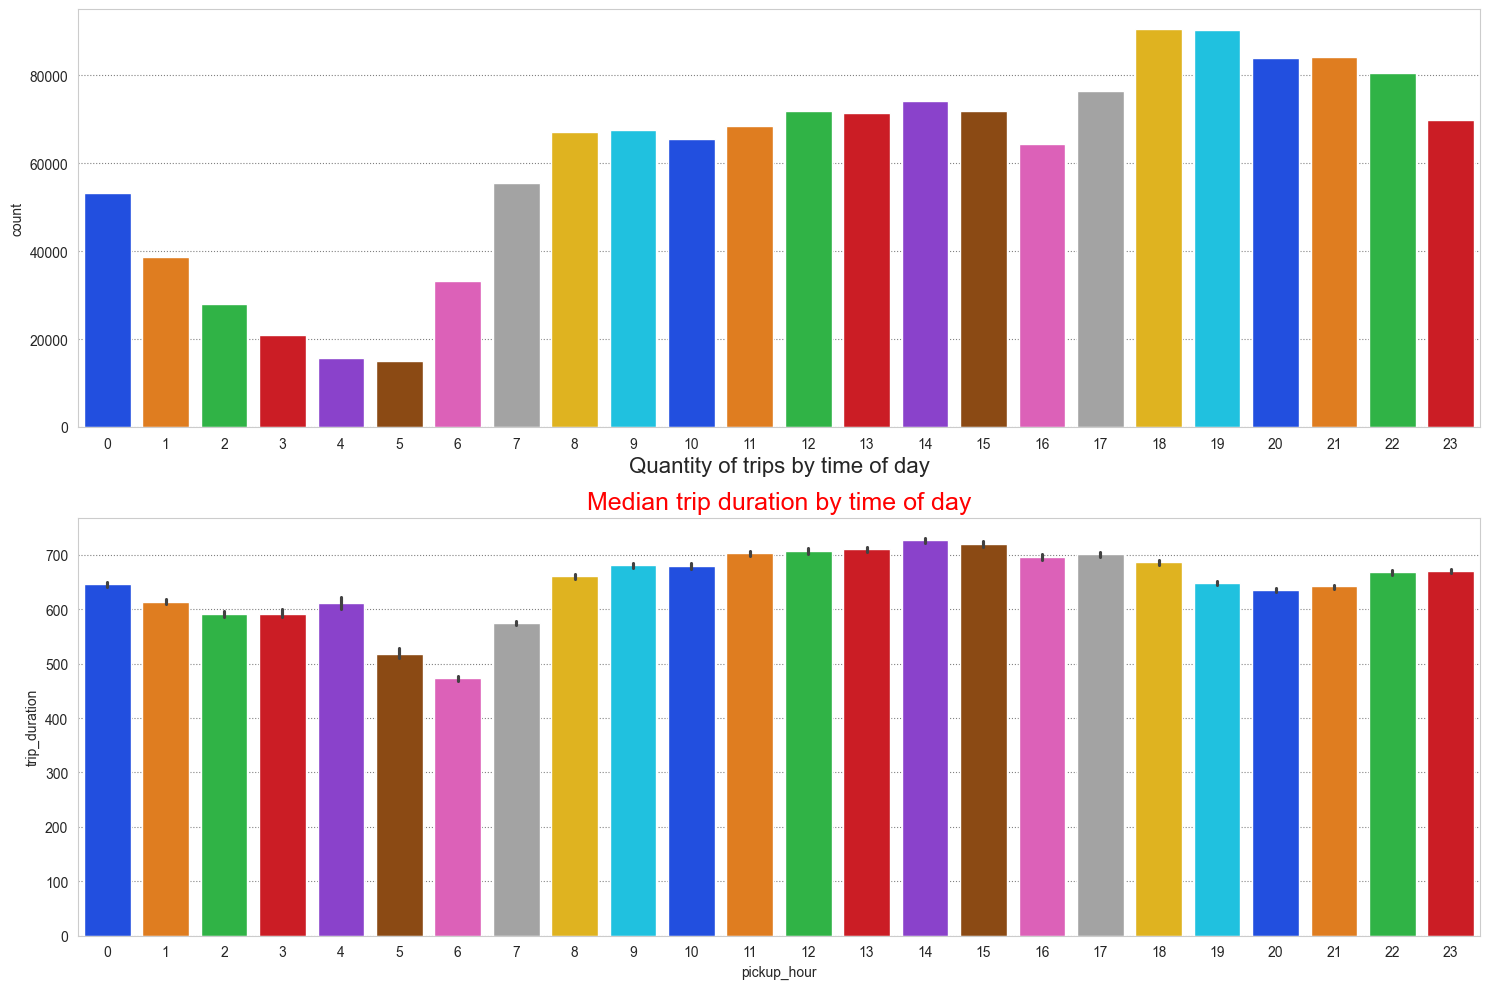

In [25]:
fig, ax = plt.subplots(2, figsize=(15, 10))
# количественная столбчатая диаграмма признака pickup_hour
sns.countplot(taxi_data, x='pickup_hour', palette='bright', ax=ax[0])
ax[0].set_xlabel('Quantity of trips by time of day', fontsize=16)
# столбчатая диаграмма продолжительности поездки в зависимости от времени суток
sns.barplot(taxi_data, x='pickup_hour', y='trip_duration', estimator='median', palette='bright', ax=ax[1])
plt.title('Median trip duration by time of day', fontsize=18, color='r')
plt.tight_layout()
plt.show()

***Вывод:***\
*Больше всего поездок на такси приходится с 18.00 до 22.00 часов, когда люди возвращаются домой после работы.*\
*Наиболее длительные поездки наблюдаем с 9.00 до 18.00, то есть обычное рабочее время дня.*\
*Таким образом, данный фактор (время суток) влияет на продолжительность поездки, но его значимость мы определим позже.*

### 3.5 Визуализация количества поездок в зависимости от дня недели (pickup_day_of_week) и зависимость продолжительсти поездок (trip_duration) от дня недели.

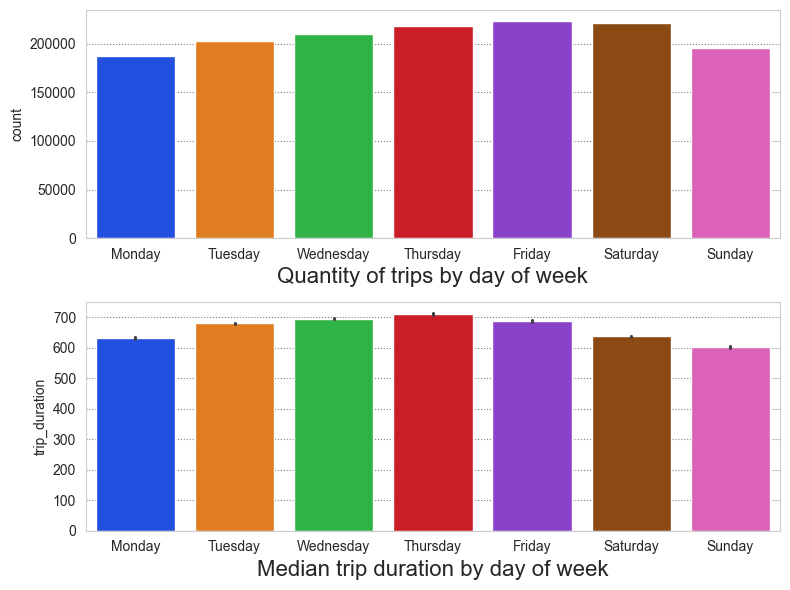

In [26]:
fig, ax = plt.subplots(2, figsize=(8, 6))
# количественная столбчатая диаграмма признака pickup_day_of_week
sns.countplot(taxi_data, x='pickup_day_of_week', palette='bright', ax=ax[0])
ax[0].set_xlabel('Quantity of trips by day of week', fontsize=16)
ax[0].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
# столбчатая диаграмма продолжительности поездки в зависимости от дня недели
sns.barplot(taxi_data, x='pickup_day_of_week', y='trip_duration', estimator='median', palette='bright', ax=ax[1])
ax[1].set_xlabel('Median trip duration by day of week', fontsize=16)
ax[1].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.tight_layout()
plt.show()

***Вывод:***\
*Четверг, пятница, суббота - наиболее популярные дни для таксистов.*\
*Наиболее длительные поездки - со вторника по пятницу, то есть рабочие дни недели.*\
*Распределение по дням недели достаточно плавное и продолжительность поездки в зависимости от дня недели не показывает сильных перепадов, досточно ровное, что указывает, что данный признак не сильно значимо влияет на целевой признак в решении поставленной задачи.*

### 3.6 Зависимость длительности поездки (trip_duration) от двух факторов одновременно: часов (pickup_hour) и дней недели (pickup_day_of_week).

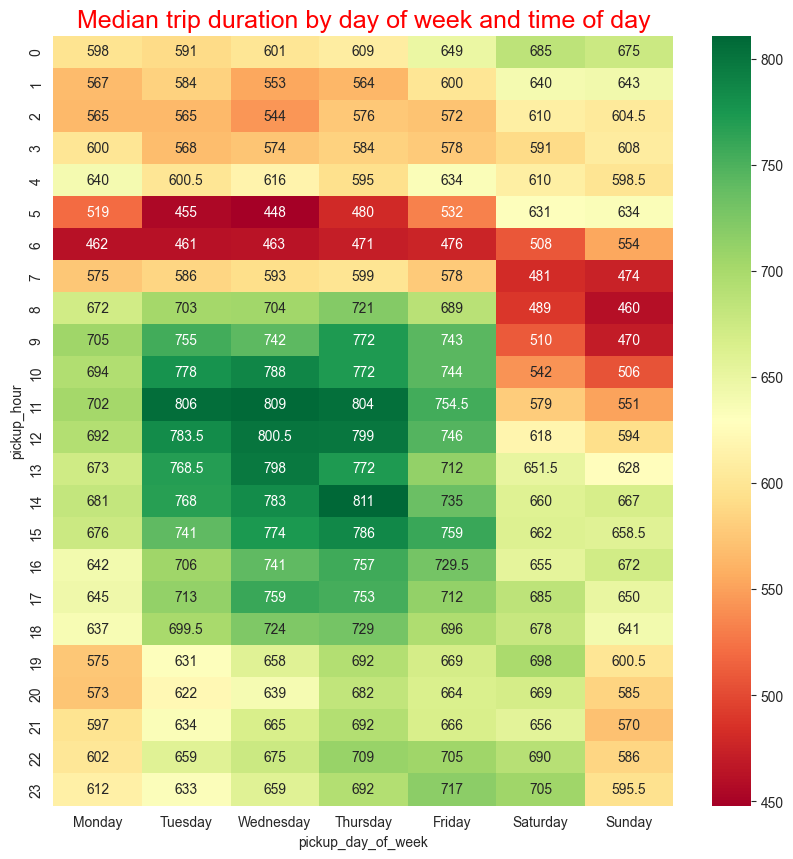

In [27]:
# создаем сводную таблицу
pivot = taxi_data.pivot_table(index='pickup_hour', columns='pickup_day_of_week', values='trip_duration', aggfunc='median')

fig = plt.figure(figsize=(10,10))
# отобразим полученную таблицу на тепловой карте
p = sns.heatmap(pivot, cmap='RdYlGn', annot=True, fmt='g')
p.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Median trip duration by day of week and time of day', fontsize=18, color='r')
plt.show()

***Вывод:***\
*Согласно тепловой карте делаем вывод, эти два фактора pickup_hour и pickup_day_of_week влияют на продолжительность поездки.*

### 3.7 Визуализация поездок по районам Нью-Йорка из координат начала поездок (pickup_longitude, pickup_latitude) и завершения поездок (dropoff_longitude, dropoff_latitude).
Георграфические координаты Нью-Йорка:\
city_long_border = (-74.03, -73.75)\
city_lat_border = (40.63, 40.85)

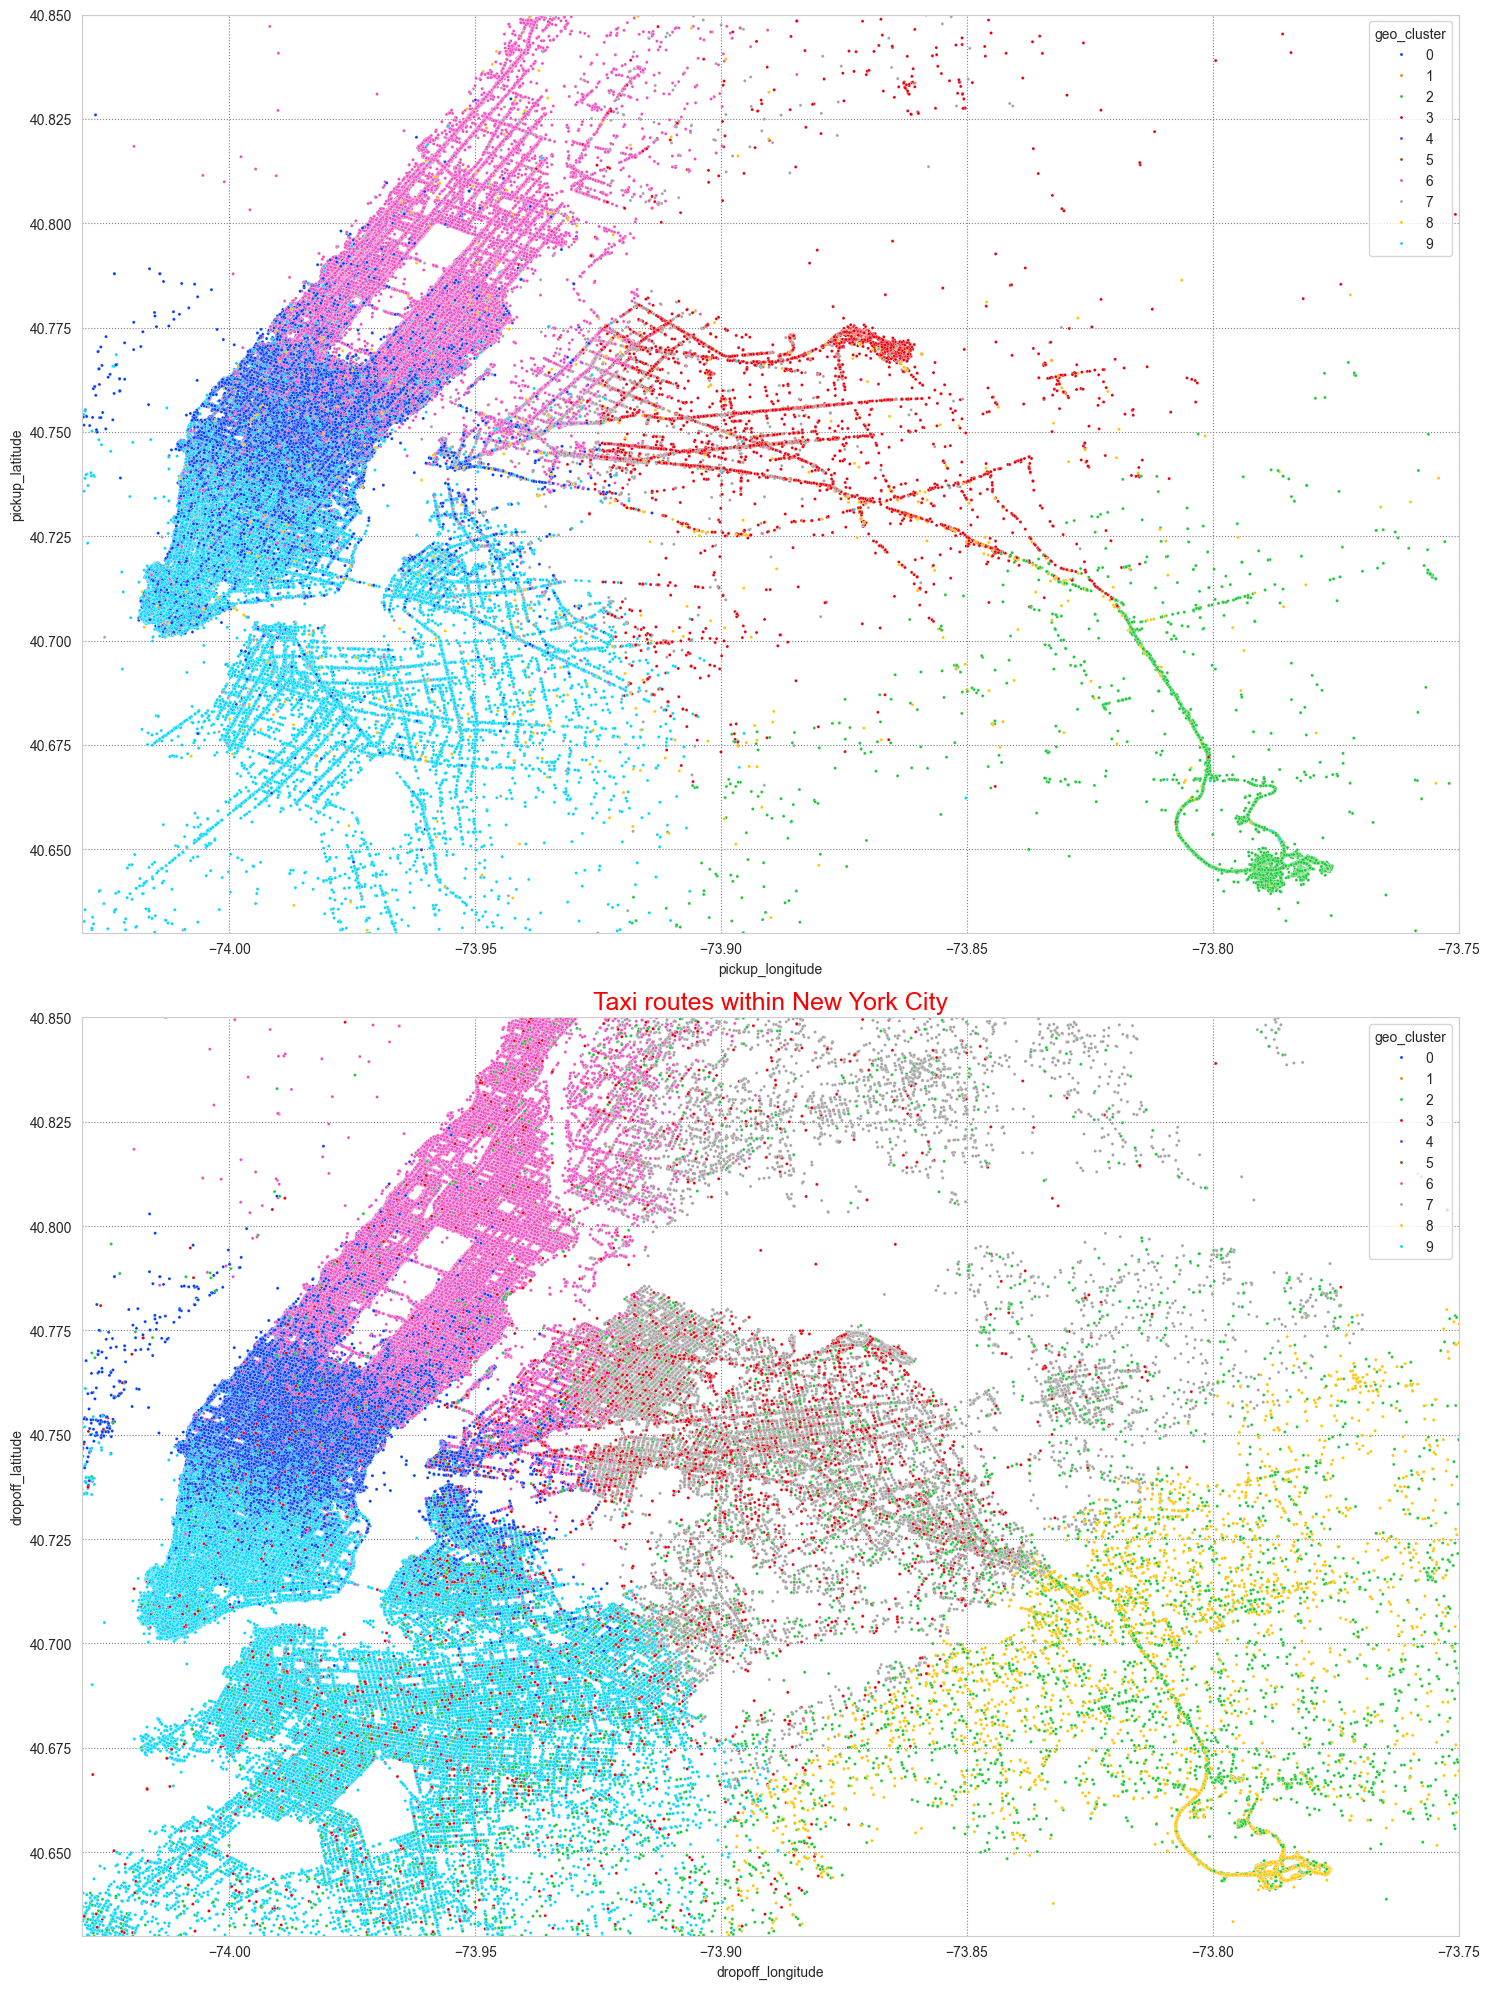

In [163]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

fig, ax = plt.subplots(2, figsize=(15,20))
# диаграмма рассеяния точек начала движения
sns.scatterplot(taxi_data, x='pickup_longitude', y='pickup_latitude', hue='geo_cluster', s=5, palette='bright', ax=ax[0])
ax[0].set(xlim=city_long_border, ylim=city_lat_border)
# диаграмма рассеяния точек завершения поездок
sns.scatterplot(taxi_data, x='dropoff_longitude', y='dropoff_latitude', hue='geo_cluster', s=5, palette='bright', ax=ax[1])
ax[1].set(xlim=city_long_border, ylim=city_lat_border)
plt.title('Taxi routes within New York City', fontsize=18, color='r')
plt.tight_layout()
plt.show()

***Вывод:***\
*Во-первых, мы действительно наблюдаем различия по районам.*\
*Во-вторых, география конечных точек гораздо шире и значительно отличается от первой карты стартовых точек.*\
*Скорее всего, географические факторы будут наиболее значимыми в решении задачи прогнозирования длительности поездки.*

## 4. Отбор и преобразование признаков

Прежде всего, нам необходимо закодировать некоторые признаки, так как многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде.

Также мы отберем только наиболее значимые признаки, чтобы моделирование было наименее ресурснозатратным, но эффективным, и избежим мультиколлинерности.

Наши данные различны по единицам измерения, поэтому, чтобы улучшить сходимость моделей, масшабируем их.

Для удобства работы сделаем копию исходной таблицы с поездками:

In [28]:
train_data = taxi_data.copy()
train_data.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_date,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,455,2016-03-14,...,5.0,1.498521,99.970196,6,4.4,8.0,27.8,0.3,None,6.122493
1,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,663,2016-06-12,...,6.0,1.805507,-117.153768,9,28.9,16.1,7.4,0.0,None,6.498282
2,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,2124,2016-01-19,...,16.0,6.385098,-159.680165,9,-6.7,16.1,24.1,0.0,None,7.661527
3,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,429,2016-04-06,...,4.0,1.485498,-172.737700,9,7.2,16.1,25.9,0.0,None,6.063785
4,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,435,2016-03-26,...,5.0,1.188588,179.473585,6,9.4,16.1,9.3,0.0,None,6.077642


### 4.1 Удаление избыточных признаков.
Мы преобразовали признак 'pickup_datetime' в полезные для моделирования признаки: время суток начала поездки и день недели, поэтому мы можем удалить его, а также теперь уже ненужный нам признак даты 'pickup_date'.

Также мы исключим признак 'dropoff_datetime' (дата и время завершения поездки), мы решаем задачу регрессии, в новых данных мы должны предсказать продолжительность поездки и новые данные не будут иметь сведений о завершении поездки.

In [29]:
train_data.drop(['dropoff_datetime', 'pickup_datetime', 'pickup_date'], axis=1, inplace=True)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 22)


### 4.2 Кодирование
1) Закодируем признак vendor_id бинарным образом, чтобы он был равен 0, если идентификатор таксопарка равен 1, и 1 — в противном случае.
2) Закодиреум номинальные категориальные признаки pickup_day_of_week, geo_cluster и events однократным кодированием OneHotEncoder из библиотеки sklearn.

In [30]:
train_data['vendor_id'] = train_data['vendor_id'].apply(lambda x: 0 if x==1 else 1)
# инициализируем кодировщик
# в параметрах указываем drop='first', чтобы удалять первый бинарный столбец и тем самым не создавать излишних признаков
# handle_unknown='ignore', чтобы код отрабатывал без ошибок в случае появления в тестовой выборке значений, отсутствующих в обучающей выборке
one_hot_encoder = preprocessing.OneHotEncoder(drop='first', handle_unknown='ignore') 
data_onehot = one_hot_encoder.fit_transform(train_data[['pickup_day_of_week', 'geo_cluster', 'events']])
# создаем список закодированных имен столбцов
column_names = one_hot_encoder.get_feature_names_out()
# создаем DataFrame из закодированных признаков
data_onehot = pd.DataFrame(data_onehot.toarray(), columns=column_names)
print(data_onehot.shape)
data_onehot.head()

(1458233, 18)


,pickup_day_of_week_1,pickup_day_of_week_2,pickup_day_of_week_3,pickup_day_of_week_4,pickup_day_of_week_5,pickup_day_of_week_6,geo_cluster_1,geo_cluster_2,geo_cluster_3,geo_cluster_4,geo_cluster_5,geo_cluster_6,geo_cluster_7,geo_cluster_8,geo_cluster_9,events_None,events_Rain,events_Snow
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


Добавим полученную таблицу с закодированными признаками в тренировочный датасет:

In [31]:

train_data = pd.concat([train_data.reset_index(drop=True).drop(['pickup_day_of_week', 'geo_cluster', 'events'], axis=1), data_onehot], 
    axis=1)
print('Shape of data: {}'.format(train_data.shape))

Shape of data: (1458233, 37)


### 4.3 Разбиение тренировочного набора данных на тренировочную и валидационную выборки.

In [32]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log. 

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [33]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

### 4.4 Отбор признаков для моделирования.
С помощью алгоритма фильтрации признаков SelectKBest отберем 25 признаков, в качестве функции отбора используем коэффициент корреляции Пирсона, параметр    f_regression.

In [34]:
selector = feature_selection.SelectKBest(feature_selection.f_regression, k=25)
selector.fit(X_train, y_train_log)
selected_cols = selector.get_feature_names_out().tolist()
selected_cols

['vendor_id',
 'passenger_count',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'pickup_hour',
 'pickup_holiday',
 'total_distance',
 'total_travel_time',
 'number_of_steps',
 'haversine_distance',
 'temperature',
 'pickup_day_of_week_1',
 'pickup_day_of_week_2',
 'pickup_day_of_week_3',
 'pickup_day_of_week_4',
 'pickup_day_of_week_5',
 'pickup_day_of_week_6',
 'geo_cluster_2',
 'geo_cluster_3',
 'geo_cluster_6',
 'geo_cluster_7',
 'geo_cluster_8',
 'geo_cluster_9']

In [35]:
# оставим в наших выборках только отобранные 25 факторов
X_train = X_train[selected_cols]
X_valid = X_valid[selected_cols]
print(X_train.shape, X_valid.shape)

(977016, 25) (481217, 25)


### 4.5 Масштабирование
Используем нормализатор MinMaxScaler из библиотеки sklearn.

In [36]:
scaler = preprocessing.MinMaxScaler()
# нормализуем тренировочную выборку
X_train = scaler.fit_transform(X_train)
# нормализуем валидационную выборку
X_valid = scaler.transform(X_valid)

## 5. Решение задачи регрессии: линейная регрессия и деревья решений

Метрика, по которой мы будем измерять качество наших моделей, -  RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$ 

### 5.1. Модель линейной регрессии.
Все параметры оставим по умолчанию, целевую переменную используем в логарифмическом масштабе.

In [37]:
lr_model = linear_model.LinearRegression()
lr_model.fit(X_train, y_train_log)
y_train_pred = lr_model.predict(X_train)
y_valid_pred = lr_model.predict(X_valid)
print('Train RMSLE: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred))))
print('Valid RMSLE: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred))))

Train RMSLE: 0.53
Valid RMSLE: 0.53


### 5.2 Модель полиномиальной регрессии 2-ой степени.

In [38]:
# создаем генератор полиномиальных признаков 2-й степени
poly =  preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train)
# преобразуем выборки
X_train_poly = poly.transform(X_train)
X_valid_poly = poly.transform(X_valid)

In [39]:
# создаем модель линейной регрессии на полиномиальных признаках
lr_poly = linear_model.LinearRegression()
lr_poly.fit(X_train_poly, y_train_log)
y_train_poly_pred = lr_poly.predict(X_train_poly)
y_valid_poly_pred = lr_poly.predict(X_valid_poly)
print('Train RMSLE: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_poly_pred))))
print('Valid RMSLE: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_poly_pred))))

Train RMSLE: 0.46
Valid RMSLE: 0.73


*Отметим, что модель на полиномиальных признаках переобучена, на это указывает большой разброс в оценках метриках.*

### 5.3 Модель полиномиальной регрессии 2-ой степени с L2-регуляризацией.

In [40]:
# применим L2-регуляризацию, чтобы избежать переобучения модели
ridge = linear_model.Ridge(alpha=1)  # alpha - коэффициент регуляризации весов регрессии
ridge.fit(X_train_poly, y_train_log)
y_train_poly_pred = ridge.predict(X_train_poly)
y_valid_poly_pred = ridge.predict(X_valid_poly)
print('Train RMSLE: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_poly_pred))))
print('Valid RMSLE: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_poly_pred))))

Train RMSLE: 0.47
Valid RMSLE: 0.48


*Качество модели мы улучшили и избежали переобучения. Попробуем еще другие алгоритмы, чтобы сделать наше предсказание еще эффективнее.*

### 5.4 Модель дерева решений.
Все параметры по умолчанию, как и прежде, используем целевую переменную в логарифмическом масштабе. 

In [41]:
tree_model = tree.DecisionTreeRegressor(random_state = 42)
tree_model.fit(X_train, y_train_log)
y_train_pred = tree_model.predict(X_train)
y_valid_pred = tree_model.predict(X_valid)
print('Train RMSLE: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred))))
print('Valid RMSLE: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred))))

Train RMSLE: 0.00
Valid RMSLE: 0.57


*Очень неудачная модель, наш алгоритм полностью подстроился под обучающую выборку, не освоив общие закономерности, и теперь обладает плохой предсказательной способностью, данная модель бесполезна.*

Поэкспериментируем с параметром глубина дерева решений max_depths в диапазоне от 7 до 20.

Построим графики изменения ошибок обеих выборок в зависимости от глубины дерева и выберем оптимальную глубину дерева, посмотрим наилучший результат на валидационной выборке.


Train & Valid RMSLE depend on depth of dt_model
    errors_train  errors_valid
7       0.444765      0.447032
8       0.436857      0.440276
9       0.429732      0.435167
10      0.422326      0.430592
11      0.414467      0.429948
12      0.405852      0.430042
13      0.395715      0.432071
14      0.383783      0.438087
15      0.370151      0.445151
16      0.355391      0.454102
17      0.339560      0.462911
18      0.322341      0.472449
19      0.303614      0.483399


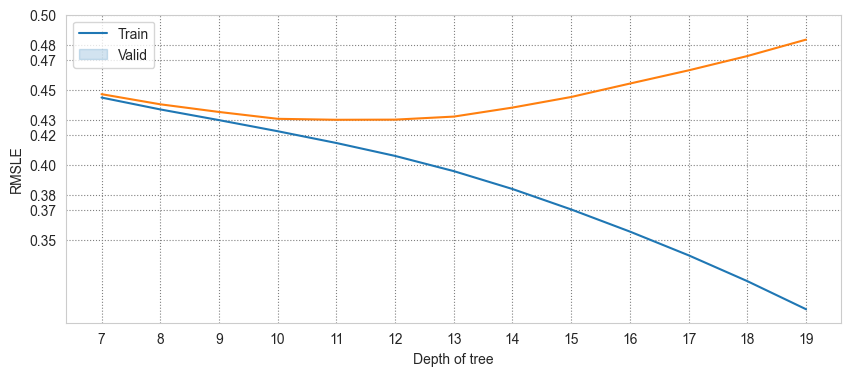

In [43]:
# создаем списки для сохранения значений метрик и глубины дерева
errors_train = []
errors_valid = []
depth=[]
# в цикле проходим по различной глубине дерева
for i in range(7,20):
    dt_model= tree.DecisionTreeRegressor(max_depth=i, random_state=42)
    dt_model.fit(X_train, y_train_log)
    y_train_pred = dt_model.predict(X_train)
    y_valid_pred = dt_model.predict(X_valid)
    # сохраняем значения метрик на каждой итерации в списки
    errors_train.append(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred)))
    errors_valid.append(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred)))
    depth.append(i)

# создадим датафрейм со значениями ошибок в зависимости от глубины дерева
error_data = pd.DataFrame({'errors_train': errors_train, 'errors_valid': errors_valid}, index=depth)
print('Train & Valid RMSLE depend on depth of dt_model', error_data, sep='\n')

# визуализация ошибок на тренировочной и валидационной выборках
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(y=errors_train, x=depth, ax=ax)
sns.lineplot(y=errors_valid, x=depth, ax=ax)
plt.xlabel('Depth of tree')
plt.ylabel('RMSLE')
plt.xticks(range(7,20))
plt.yticks(np.linspace(0.35, 0.50, 10).round(2))
plt.legend(['Train', 'Valid'])
plt.show()

*Лучший показатель метрики у модели с глубиной дерева 11, данная модель имеет ошибку RMSLE на тренировочной выборке 0.41 и на валидационной 0.43.*

## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Простые алгоритмы линейной регрессии или дерева решений уступают ансамблевым. Продолжим улучшать качество нашей модели с помощью ансамблевых.

### 6.1 Модель случайного леса.

In [44]:
rf_model = ensemble.RandomForestRegressor(n_estimators=200,           # количество деревьев
                                          max_depth=12,               # глубина дерева
                                          criterion='squared_error',  # критерий информативности
                                          min_samples_split = 20,     # минимальное число объектов, необходимое для того, чтобы узел дерева мог бы расщепиться
                                          random_state=42)
rf_model.fit(X_train, y_train_log)
y_train_pred = rf_model.predict(X_train)
y_valid_pred = rf_model.predict(X_valid)
print('Train RMSLE: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred))))
print('Valid RMSLE: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred))))

Train RMSLE: 0.40
Valid RMSLE: 0.41


### 6.2 Модель градиентного бустинга над деревьями решений.

In [45]:
grad_boost = ensemble.GradientBoostingRegressor(learning_rate=0.5,      # темп(шаг) обучения
                                                n_estimators=100,       # количество деревьев
                                                max_depth=6,            # глубина дерева
                                                min_samples_split=30,   # минимальное число объектов, необходимое для того, чтобы узел дерева мог бы расщепиться
                                                random_state=42)
grad_boost.fit(X_train, y_train_log)
y_train_pred = grad_boost.predict(X_train)
y_valid_pred = grad_boost.predict(X_valid)
print('Train RMSLE: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred))))
print('Valid RMSLE: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred))))

Train RMSLE: 0.37
Valid RMSLE: 0.39


### 6.3 Сравнение значений метрик моделей

In [46]:
score_data = pd.DataFrame({
    'models': ['Линейная регрессия', 'Полиномиальная регрессия', 'Ридж-регрессия', 'Дерево решений',
               'Модель случайного леса', 'Градиентный бустинг'],
    'Train RMSLE': [0.53, 0.46, 0.47, 0.41, 0.40, 0.37],
    'Valid RMSLE': [0.53, 0.73, 0.48, 0.43, 0.41, 0.39]
    })
score_data.style.highlight_between(subset='Valid RMSLE', left=0.30, right=0.40, color='yellowgreen')

,models,Train RMSLE,Valid RMSLE
0,Линейная регрессия,0.530000,0.530000
1,Полиномиальная регрессия,0.460000,0.730000
2,Ридж-регрессия,0.470000,0.480000
3,Дерево решений,0.410000,0.430000
4,Модель случайного леса,0.400000,0.410000
5,Градиентный бустинг,0.370000,0.390000


### 6.4 Определение самых важных характеристик из набора данных для предсказания целевой переменной - длительности поездки.

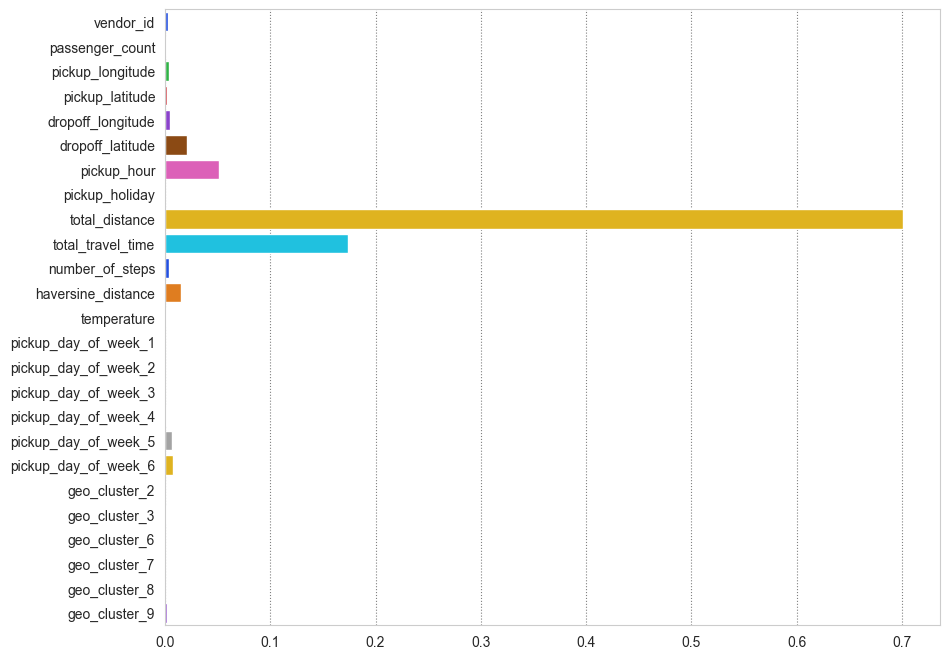

In [48]:
dt_model= tree.DecisionTreeRegressor(max_depth=11, random_state=42)
dt_model.fit(X_train, y_train_log)
fig = plt.figure(figsize=(10, 8))
features = selected_cols
feature_importance = dt_model.feature_importances_
sns.barplot(y=features, x=feature_importance, palette='bright')
plt.show()

***Вывод:***\
***Лучшей предсказательной способностью для решения поставленной задачи обладает ансамблевая модель градиентного бустинга.***\
***Топ-5 факторов, влиящих на продолжительность поездки являются:***
* ***total_distance*** — кратчайшее дорожное расстояние (в метрах) из точки, в которой был включён счётчик, до точки, в которой счётчик был выключен (согласно OSRM);
* ***total_travel_time*** — наименьшее время поездки (в секундах) из точки, в которой был включён счётчик, до точки, в которой счётчик был выключен (согласно OSRM);
* ***pickup_hour*** - время суток;
* ***dropoff_latitude*** - конечная точка пути;
* ***haversine_distance*** — расстояние по формуле гаверсинуса между точкой, в которой был включён счетчик, и точкой, в которой счётчик был выключен.

### 6.5 Расчет MeAE на модели градиентного бустинга.
MeAE - в sklearn функция median_absolute_error
$$ MeAE = median(|y_i-\hat{y_i}|)$$

Переведем значение метрики MeAE в минуты.

In [49]:
# переведем целевой признак в изначальное состояние
y_valid = np.exp(y_valid_log) - 1
y_pred = np.exp(y_valid_pred) - 1
print('Valid MeAE: {:.1f} min'.format(metrics.median_absolute_error(y_valid, y_pred)/60))

Valid MeAE: 1.8 min


***Наша модель градиентного бустинга в большинстве случаев ошибается 1.8 минуты, мы получили очень хороший результат.***

## 7. Применение лучшей построенной модели на тестовой выборке.

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных для создания submission.

In [53]:
test_data = pd.read_csv("data/Project5_test_data.zip")
osrm_data_test = pd.read_csv("data/Project5_osrm_data_test.zip")
test_id = test_data['id']

Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:
* Перевести признак pickup_datetime в формат datetime;
* Добавить новые признаки (временные, географические, погодные и другие факторы);
* Произвести очистку данных от пропусков;
* Произвести кодировку категориальных признаков:
    * Закодировать бинарные признаки;
    * Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler.


In [54]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)

test_data = add_cluster_features(test_data)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data_onehot = one_hot_encoder.fit_transform(test_data[['pickup_day_of_week', 'geo_cluster', 'events']]).toarray()
column_names = one_hot_encoder.get_feature_names_out(['pickup_day_of_week', 'geo_cluster', 'events'])
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(['pickup_day_of_week', 'geo_cluster', 'events'], axis=1), test_data_onehot], 
    axis=1
)
X_test = test_data[selected_cols]
X_test = scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

Shape of data: (625134, 25)


In [55]:
# делаем предсказание для тестового набора данных
y_test_pred = grad_boost.predict(X_test)
# разлогарифмируем вектор предсказаний
y_test_predict = np.exp(y_test_pred) - 1

In [56]:
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('data/submission_gb.csv', index=False)